## 🎯 Objective

> ### Problem Statement:  
"How can we accurately predict delivery time (`Delivery_Time_min`) based on factors such as distance, weather, traffic level, time of day, vehicle type, preparation time, and courier experience?"

> ### Business Insight:  
- Help food delivery platforms provide more accurate delivery estimates.  
- Improve customer satisfaction through better predictions.  
- Optimize resource management (e.g., courier allocation).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

> ### Preview first 5 rows of the dataset

In [335]:
df = pd.read_csv("Food_Delivery_Times.csv")
print("Dataset Preview:")
df.head()

Dataset Preview:


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


> ### Descriptive statistics for numerical columns

In [336]:
print("\nDescriptive Statistics:")
df.describe()


Descriptive Statistics:


,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,970.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.579381,56.732000
std,288.819436,5.696656,7.204553,2.914394,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


> ### Dataset information including data types and missing values

In [337]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


> ### Dataset Overview
The dataset consists of 1000 entries and 9 columns:
- `Order_ID`: Unique identifier for each order.
- `Distance_km`: The delivery distance in kilometers.
- `Weather`: Weather conditions during the delivery, including Clear, Rainy, Snowy, Foggy, and Windy.
- `Traffic_Level`: Traffic conditions categorized as Low, Medium, or High.
- `Time_of_Day`: The time when the delivery took place, categorized as Morning, Afternoon, Evening, or Night.
- `Vehicle_Type`: Type of vehicle used for delivery, including Bike, Scooter, and Car.
- `Preparation_Time_min`: The time required to prepare the order, measured in minutes.
- `Courier_Experience_yrs`: Experience of the courier in years.
- `Delivery_Time_min`: The total delivery time in minutes (target variable).

> ### Count missing values in each column

In [338]:
print("\nMissing Values per Column:")
df.isnull().sum()


Missing Values per Column:


Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

> Since these missing values are in categorical and numerical columns, typical handling methods include:

- For categorical columns (Weather, Traffic_Level, Time_of_Day):

    - Impute missing values with the most frequent category (mode), or

    - Use a new category like 'Unknown' if appropriate

- For numerical column (Courier_Experience_yrs):

    - Impute missing values using mean or median, depending on distribution

    - Alternatively, if missing is large, consider more advanced methods or dropping rows (but since only 30 rows, imputation preferred)

In [339]:
# Check mode for categorical columns
df[['Weather', 'Traffic_Level', 'Time_of_Day']].mode()

for col in ['Weather', 'Traffic_Level', 'Time_of_Day']:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)

# Impute numerical column with median
median_exp = df['Courier_Experience_yrs'].median()
df['Courier_Experience_yrs'] = df['Courier_Experience_yrs'].fillna(median_exp)

# Verify no missing values remain
print("\nMissing Values after Imputation:")
print(df.isnull().sum())


Missing Values after Imputation:
Order_ID                  0
Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64


The dataset are safe from missing value :)

> ### Drop **order_id** because it's not used in this project

In [340]:
# Drop the Order_ID column as it is not useful for prediction
df = df.drop(columns=['Order_ID'])

# Verify the column is dropped
print("Columns after dropping Order_ID:")
df.head()


Columns after dropping Order_ID:


,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,19.03,Clear,Low,Morning,Bike,16,5.0,68


> ### Check duplicated data

In [341]:
len(df.drop_duplicates()) / len(df)

1.0

- The dataset are safe from duplicated data

> ### Check Unique Values

In [342]:
for col in ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']:
    print(f"\nUnique values in {col}:")
    print(df[col].dropna().unique())


Unique values in Weather:
['Windy' 'Clear' 'Foggy' 'Rainy' 'Snowy']

Unique values in Traffic_Level:
['Low' 'Medium' 'High']

Unique values in Time_of_Day:
['Afternoon' 'Evening' 'Night' 'Morning']

Unique values in Vehicle_Type:
['Scooter' 'Bike' 'Car']


> ### Target Distribution

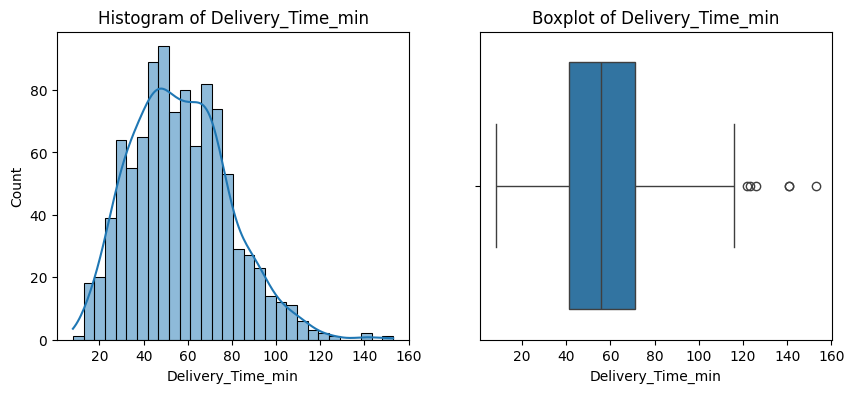

Summary statistics of Delivery_Time_min:
count    1000.000000
mean       56.732000
std        22.070915
min         8.000000
25%        41.000000
50%        55.500000
75%        71.000000
max       153.000000
Name: Delivery_Time_min, dtype: float64
Skewness: 0.507
Kurtosis: 0.291


In [343]:


plt.figure(figsize=(10,4))

# Histogram
plt.subplot(1,2,1)
sns.histplot(df['Delivery_Time_min'], bins=30, kde=True)
plt.title('Histogram of Delivery_Time_min')

# Boxplot
plt.subplot(1,2,2)
sns.boxplot(x=df['Delivery_Time_min'])
plt.title('Boxplot of Delivery_Time_min')

plt.show()

# Summary statistics
print("Summary statistics of Delivery_Time_min:")
print(df['Delivery_Time_min'].describe())
print(f"Skewness: {df['Delivery_Time_min'].skew():.3f}")
print(f"Kurtosis: {df['Delivery_Time_min'].kurtosis():.3f}")


> ### Conclusion of Delivery_Time_min Distribution Analysis

- Distribution Shape
    - The histogram shows a roughly symmetric distribution with a slight right skew (positive skewness of 0.507), indicating that most delivery times are clustered around the mean, but there are some longer delivery times extending the tail to the right.  
    - The kurtosis value of 0.291 suggests a distribution with lighter tails and a flatter peak compared to a normal distribution (mesokurtic).

- Central Tendency and Spread
    - The mean delivery time is approximately 56.7 minutes, and the median is 55.5 minutes, which are close, further supporting the near-symmetric distribution.  
    - The standard deviation is 22.1 minutes, indicating moderate variability in delivery times.

- Range and Outliers
    - The minimum delivery time is 8 minutes, and the maximum is 153 minutes.  
    - The boxplot shows a few potential outliers on the higher end (right side), suggesting some unusually long delivery times.

- Practical Implications
    - Most deliveries (50%) are completed between 41 minutes (Q1) and 71 minutes (Q3).  
    - The slight right skew and outliers suggest occasional delays, which may warrant investigation into their causes (e.g., traffic, distance, or operational inefficiencies).


> ### Data Manipulation, Feature Engineering
### `Encoding Categorical Variables Explanation`

- Categorical Columns  
    - Weather  
    - Traffic_Level  
    - Time_of_Day  
    - Vehicle_Type  

- Encoding Method: One-Hot Encoding  
    - Suitable for nominal categorical variables without intrinsic order.  
    - Converts each category into a separate binary (0/1) column.  
    - Avoids implying any ordinal relationship between categories.  
    - `drop_first=True` avoids multicollinearity by dropping one category per feature.

- Result  
    - The dataset becomes fully numeric and ready for machine learning models.  
    - Increases the number of columns but preserves all category information.

- Implementation  
    - Using `pandas.get_dummies()` for simplicity and efficiency.  
    - This method automatically handles all specified categorical columns.


In [344]:
# Perform One-Hot Encoding on all categorical columns WITHOUT dropping any category
df_encoded = pd.get_dummies(
    df,
    columns=['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type'],
    drop_first=False  # Keep all categories explicitly
)

# Show all column names after encoding
print("Columns after encoding:")
df_encoded.columns.tolist()

Columns after encoding:


['Distance_km',
 'Preparation_Time_min',
 'Courier_Experience_yrs',
 'Delivery_Time_min',
 'Weather_Clear',
 'Weather_Foggy',
 'Weather_Rainy',
 'Weather_Snowy',
 'Weather_Windy',
 'Traffic_Level_High',
 'Traffic_Level_Low',
 'Traffic_Level_Medium',
 'Time_of_Day_Afternoon',
 'Time_of_Day_Evening',
 'Time_of_Day_Morning',
 'Time_of_Day_Night',
 'Vehicle_Type_Bike',
 'Vehicle_Type_Car',
 'Vehicle_Type_Scooter']

In [345]:
# Preview the first few rows of the encoded dataframe
df_encoded.head()

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Clear,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Traffic_Level_High,Traffic_Level_Low,Traffic_Level_Medium,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Vehicle_Type_Bike,Vehicle_Type_Car,Vehicle_Type_Scooter
0,7.93,12,1.0,43,False,False,False,False,True,False,True,False,True,False,False,False,False,False,True
1,16.42,20,2.0,84,True,False,False,False,False,False,False,True,False,True,False,False,True,False,False
2,9.52,28,1.0,59,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True
3,7.44,5,1.0,37,False,False,True,False,False,False,False,True,True,False,False,False,False,False,True
4,19.03,16,5.0,68,True,False,False,False,False,False,True,False,False,False,True,False,True,False,False


In [346]:
for col in ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']:
    print(f"\nUnique values in {col}:")
    print(df[col].dropna().unique())


Unique values in Weather:
['Windy' 'Clear' 'Foggy' 'Rainy' 'Snowy']

Unique values in Traffic_Level:
['Low' 'Medium' 'High']

Unique values in Time_of_Day:
['Afternoon' 'Evening' 'Night' 'Morning']

Unique values in Vehicle_Type:
['Scooter' 'Bike' 'Car']


> ### Split dataset

In [347]:
from sklearn.model_selection import train_test_split

# Define feature and target variables explicitly
feature = df_encoded.drop(columns=['Delivery_Time_min'])
target = df_encoded[['Delivery_Time_min']]

# Split dataset into training and testing sets (80% train, 20% test)
feature_train, feature_test, target_train, target_test = train_test_split(
    feature, target, test_size=0.2, random_state=42
)

# Print the shapes of the resulting datasets
print(f"Training features shape: {feature_train.shape}")
print(f"Testing features shape: {feature_test.shape}")
print(f"Training target shape: {target_train.shape}")
print(f"Testing target shape: {target_test.shape}")


Training features shape: (800, 18)
Testing features shape: (200, 18)
Training target shape: (800, 1)
Testing target shape: (200, 1)


> #### Check the outlier

In [348]:
import scipy.stats as stats

def check_plot(x_train, variable):
    # fungsi mengambil kerangka data (df) dan
    # variabel yang diminati sebagai argumen

    # tentukan ukuran gambar
    plt.figure(figsize=(16, 4))


    # box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=x_train[variable])
    plt.title('Boxplot')

    plt.show()

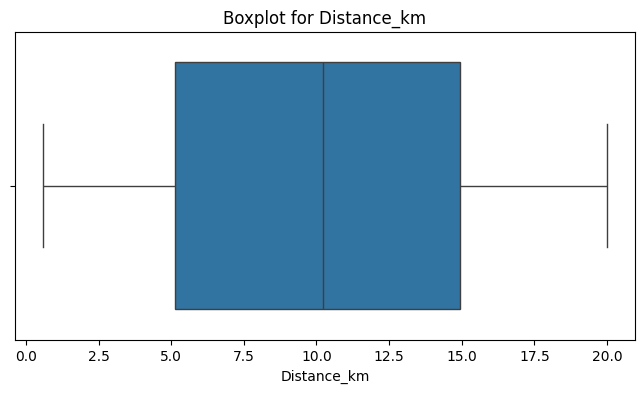

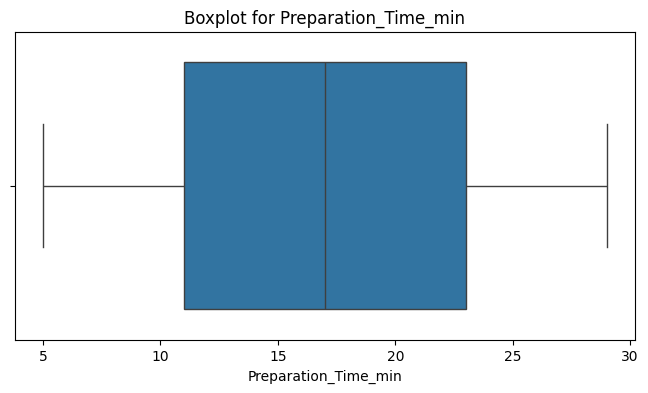

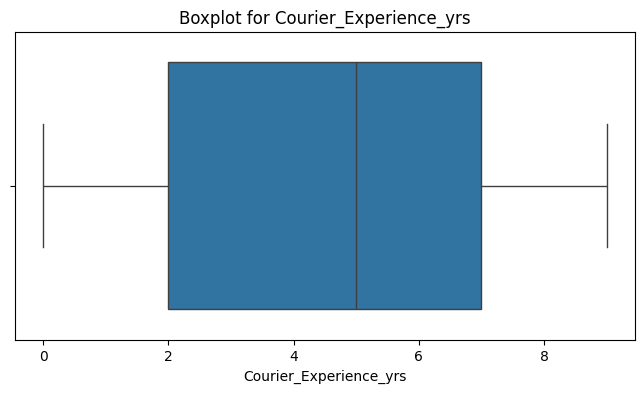

In [349]:
# List of numeric columns from feature_train
numeric_columns = feature_train.select_dtypes(include=['number']).columns

# Columns relevant for outlier checking in your project
# Adjust this list to your dataset's numeric features
columns_to_check = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']

def check_plot(data, col):
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

# Loop through numeric columns and plot boxplots for selected features
for col in numeric_columns:
    if col in columns_to_check:
        check_plot(feature_train, col)

- There are no Outliers

> ### Scalling

In [350]:
df_encoded.head()

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Clear,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Traffic_Level_High,Traffic_Level_Low,Traffic_Level_Medium,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Vehicle_Type_Bike,Vehicle_Type_Car,Vehicle_Type_Scooter
0,7.93,12,1.0,43,False,False,False,False,True,False,True,False,True,False,False,False,False,False,True
1,16.42,20,2.0,84,True,False,False,False,False,False,False,True,False,True,False,False,True,False,False
2,9.52,28,1.0,59,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True
3,7.44,5,1.0,37,False,False,True,False,False,False,False,True,True,False,False,False,False,False,True
4,19.03,16,5.0,68,True,False,False,False,False,False,True,False,False,False,True,False,True,False,False


In [360]:
# Select only numerical columns for scaling
numerical_features = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']

# Separate the numerical features from the rest
X_train_numerical = feature_train[numerical_features]
X_test_numerical = feature_test[numerical_features]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit scaler on training numerical features
scaler.fit(X_train_numerical)

# Transform training and testing numerical features
X_train_scaled = scaler.transform(X_train_numerical)
X_test_scaled = scaler.transform(X_test_numerical)

# Convert scaled data back to DataFrame with original column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numerical_features, index=feature_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numerical_features, index=feature_test.index)

# Combine scaled numerical features with original one-hot encoded features (no scaling needed for them)
X_train_final = pd.concat([X_train_scaled, feature_train.drop(columns=numerical_features)], axis=1)
X_test_final = pd.concat([X_test_scaled, feature_test.drop(columns=numerical_features)], axis=1)


> ### Model Training and Evaluation

- #### Recommended Models for Delivery Time Prediction

    - Based on recent studies and practical considerations, we focus on three strong candidate models for predicting delivery time:

    1. **XGBoost (XGBRegressor)[1]**
        - XGBoost demonstrated the best performance in predicting food delivery times with an R² of 0.82 and low MAE and RMSE, effectively capturing complex patterns in the data.
        - Important features like weather, traffic, and courier profile are well handled by this ensemble method.
        - **Conclusion:** XGBoost is highly recommended for logistic or food delivery time prediction projects.
        - Reference: https://www.researchgate.net/publication/382020188_A_Comparative_Analysis_of_Machine_Learning_Models_for_Time_Prediction_in_Food_Delivery_Operations

    2. **LightGBM**
        - In a study on food delivery time prediction in Indian cities, LightGBM outperformed Random Forest and XGBoost statistically, with an R² of 0.76.
        - It is especially suitable when model speed and efficiency are priorities.
        - **Conclusion:** LightGBM is competitive and recommended for optimizing prediction speed and resource usage.
        - Reference: https://arxiv.org/html/2503.15177v1

    3. **Random Forest**
        - Random Forest has been used effectively for delivery time prediction with average accuracy around 83.86% depending on implementation.
        - Known for its flexibility and ease of use on various data types, it offers stable and interpretable results.
        - **Conclusion:** Random Forest remains a good choice for stable and interpretable models.
        - Reference: https://ijadis.org/index.php/ijadis/article/view/1281


- #### Model Candidates for This Project
    - XGBoost (XGBRegressor)
    - LightGBM
    - Random Forest

> ### Model Performance Evaluation Overview

- We will evaluate the performance of several regression models on the delivery time prediction task:
  - **Before hyperparameter tuning:** Using default model settings.
  - **After hyperparameter tuning:** Optimizing key parameters to improve accuracy.

- The main metrics to assess model performance will be:
  - **R-squared (R²):** Proportion of variance explained by the model. Higher is better.
  - **Mean Absolute Error (MAE):** Average absolute difference between predicted and actual values. Lower is better.
  - **Root Mean Squared Error (RMSE):** Square root of average squared differences. Penalizes larger errors more. Lower is better.

- After evaluation, we will compare metrics to select the best performing model.


> ### Before Hyperparameter Tuning

In [362]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

import numpy as np

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit the model on the training set
    model.fit(X_train, y_train.values.ravel())
    
    # Predict on the testing set
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate evaluation metrics for both training and testing
    r2_train = r2_score(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # Display results for both training and testing
    print(f"Model: {model.__class__.__name__}")
    
    print("### Training Performance ###")
    print(f"R²: {r2_train:.4f}")
    print(f"MAE: {mae_train:.4f}")
    print(f"RMSE: {rmse_train:.4f}\n")

    print("### Testing Performance ###")
    print(f"R²: {r2_test:.4f}")
    print(f"MAE: {mae_test:.4f}")
    print(f"RMSE: {rmse_test:.4f}\n")
    
    return r2_train, mae_train, rmse_train, r2_test, mae_test, rmse_test

# Instantiate models with default hyperparameters
xgb = XGBRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

# Train and evaluate models
print("### Performance Before Hyperparameter Tuning ###\n")
evaluate_model(xgb, X_train_final, target_train, X_test_final, target_test)
evaluate_model(lgbm, X_train_final, target_train, X_test_final, target_test)
evaluate_model(rf, X_train_final, target_train, X_test_final, target_test)


### Performance Before Hyperparameter Tuning ###

Model: XGBRegressor
### Training Performance ###
R²: 0.9991
MAE: 0.4696
RMSE: 0.6842

### Testing Performance ###
R²: 0.7361
MAE: 7.8191
RMSE: 10.8767

Model: LGBMRegressor
### Training Performance ###
R²: 0.9232
MAE: 3.8912
RMSE: 6.1695

### Testing Performance ###
R²: 0.7860
MAE: 7.1137
RMSE: 9.7948

Model: RandomForestRegressor
### Training Performance ###
R²: 0.9555
MAE: 3.0112
RMSE: 4.6983

### Testing Performance ###
R²: 0.7920
MAE: 6.8214
RMSE: 9.6557



(0.9554712862769785,
 3.0112125000000005,
 4.698289436060746,
 0.7919974260808378,
 6.82145,
 9.65569078315995)

### **Interpretation of Model Performance Before Hyperparameter Tuning**

- **XGBoost Regressor** shows excellent **training performance** with:
  - **R² (Training)**: 0.9991 (indicating that the model explains nearly 100% of the variance in the training data).
  - **MAE (Training)**: 0.4696 (very small average error in minutes).
  - **RMSE (Training)**: 0.6842 (very low penalty on large errors).

  However, its **testing performance** is not as impressive:
  - **R² (Testing)**: 0.7361 (explains ~74% of variance in the test data).
  - **MAE (Testing)**: 7.8191 (larger average error in minutes compared to training).
  - **RMSE (Testing)**: 10.8767 (higher penalty on large errors).

  **Key Insight**: The **XGBoost model** may be overfitting, as it performs exceptionally well on the training set but struggles with the test data.

---

- **LightGBM Regressor** performs well overall, with:
  - **R² (Training)**: 0.9232 (explains ~92% of variance in the training set).
  - **MAE (Training)**: 3.8912 (relatively low average error).
  - **RMSE (Training)**: 6.1695 (moderate penalty on large errors).

  The **testing performance** is solid:
  - **R² (Testing)**: 0.7860 (explains ~79% of variance in the test data).
  - **MAE (Testing)**: 7.1137 (error is relatively manageable but higher than training).
  - **RMSE (Testing)**: 9.7948 (moderate penalty on large errors).

  **Key Insight**: **LightGBM** shows good generalization to the test set, with decent performance across both training and testing data.

---

- **Random Forest Regressor** shows strong **training performance** with:
  - **R² (Training)**: 0.9555 (explains ~96% of variance in the training data).
  - **MAE (Training)**: 3.0112 (fairly low average error).
  - **RMSE (Training)**: 4.6983 (moderate penalty on large errors).

  **Testing performance** is also good:
  - **R² (Testing)**: 0.7920 (explains ~79% of variance in the test data).
  - **MAE (Testing)**: 6.8214 (error is reasonable but higher than training).
  - **RMSE (Testing)**: 9.6557 (moderate penalty on large errors).

  **Key Insight**: **Random Forest** provides a good balance between training and testing performance, with good generalization.

---

### **Summary**
- **XGBoost Regressor** performs exceptionally on training data but shows signs of **overfitting**, as its test performance is significantly lower.
- **LightGBM Regressor** provides solid performance with **good generalization** to the test set, performing well in both training and testing.
- **Random Forest Regressor** offers **balanced performance** with strong results on both training and test data, making it a good candidate as the baseline model.

### **Next Steps**:
- All models, especially **XGBoost**, can likely benefit from **hyperparameter tuning** to improve test performance.
- **LightGBM** and **Random Forest** appear to be strong models for further tuning.


> ### Approach for Hyperparameter Tuning and Model Comparison

- We will perform hyperparameter tuning **separately for each model** (XGBoost, LightGBM, Random Forest) to find their best parameter settings individually.
- After tuning each model, we will evaluate their performance on the test set.
- Finally, we will compare:
  - The best tuned model performances against each other.
  - Each tuned model versus its default (untuned) version.
- This stepwise approach helps us select the **best performing model and configuration** for the delivery time prediction task.

---

### Plan
1. Tune **XGBoost** hyperparameters and evaluate.  
2. Tune **LightGBM** hyperparameters and evaluate.  
3. Tune **Random Forest** hyperparameters and evaluate.  
4. Compare all tuned models and their default counterparts.  
5. Decide on the best model and whether tuning significantly improves performance.

---


> ### Hyperparameter Tuning for XGBoost (Step 1)

- We will start by tuning the **XGBoost Regressor** hyperparameters using `RandomizedSearchCV`.
- This will help us find the best combination of parameters to improve prediction accuracy.
- We use 5-fold cross-validation and optimize for R² score.


In [363]:
from sklearn.model_selection import RandomizedSearchCV
# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
}

# Initialize XGBoost Regressor
xgb = XGBRegressor(random_state=42)

# Setup RandomizedSearchCV for XGBoost
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=20,
    cv=5,
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
xgb_search.fit(X_train_final, target_train)

# Print best parameters and best score from RandomizedSearchCV
print("Best parameters found for XGBoost:")
print(xgb_search.best_params_)
print(f"Best CV R² score: {xgb_search.best_score_:.4f}")

# Get the best model from the search
best_xgb = xgb_search.best_estimator_

# Predict on training data to evaluate performance on train set
y_pred_train = best_xgb.predict(X_train_final)
r2_train = r2_score(target_train, y_pred_train)
mae_train = mean_absolute_error(target_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(target_train, y_pred_train))

# Predict on test data to evaluate performance on test set
y_pred_test = best_xgb.predict(X_test_final)
r2_test = r2_score(target_test, y_pred_test)
mae_test = mean_absolute_error(target_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(target_test, y_pred_test))

# Print the performance on both training and testing data
print("\nPerformance of Tuned XGBoost on Training Data:")
print(f"R²: {r2_train:.4f}")
print(f"MAE: {mae_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")

print("\nPerformance of Tuned XGBoost on Test Data:")
print(f"R²: {r2_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found for XGBoost:
{'subsample': 0.6, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01}
Best CV R² score: 0.7313

Performance of Tuned XGBoost on Training Data:
R²: 0.7969
MAE: 6.3983
RMSE: 10.0350

Performance of Tuned XGBoost on Test Data:
R²: 0.8044
MAE: 6.5591
RMSE: 9.3636


> ### Hyperparameter Tuning for LightGBM (Step 2)

- Next, we tune the **LightGBM Regressor** hyperparameters using `RandomizedSearchCV`.
- The goal is to find the best parameter combination that maximizes R² score using 5-fold cross-validation.


In [364]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Define parameter grid for LightGBM
lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, 15, -1],
}

# Initialize LightGBM Regressor
lgbm = LGBMRegressor(random_state=42)

# Setup RandomizedSearchCV for LightGBM
lgbm_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_param_grid,
    n_iter=20,
    cv=5,
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
lgbm_search.fit(X_train_final, target_train)

# Print best parameters and best score from RandomizedSearchCV
print("Best parameters found for LightGBM:")
print(lgbm_search.best_params_)
print(f"Best CV R² score: {lgbm_search.best_score_:.4f}")

# Get the best model from the search
best_lgbm = lgbm_search.best_estimator_

# Predict on training data to evaluate performance on train set
y_pred_train_lgbm = best_lgbm.predict(X_train_final)
r2_train_lgbm = r2_score(target_train, y_pred_train_lgbm)
mae_train_lgbm = mean_absolute_error(target_train, y_pred_train_lgbm)
rmse_train_lgbm = np.sqrt(mean_squared_error(target_train, y_pred_train_lgbm))

# Predict on test data to evaluate performance on test set
y_pred_test_lgbm = best_lgbm.predict(X_test_final)
r2_test_lgbm = r2_score(target_test, y_pred_test_lgbm)
mae_test_lgbm = mean_absolute_error(target_test, y_pred_test_lgbm)
rmse_test_lgbm = np.sqrt(mean_squared_error(target_test, y_pred_test_lgbm))

# Print the performance on both training and testing data
print("\nPerformance of Tuned LightGBM on Training Data:")
print(f"R²: {r2_train_lgbm:.4f}")
print(f"MAE: {mae_train_lgbm:.4f}")
print(f"RMSE: {rmse_train_lgbm:.4f}")

print("\nPerformance of Tuned LightGBM on Test Data:")
print(f"R²: {r2_test_lgbm:.4f}")
print(f"MAE: {mae_test_lgbm:.4f}")
print(f"RMSE: {rmse_test_lgbm:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found for LightGBM:
{'num_leaves': 31, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05}
Best CV R² score: 0.7215

Performance of Tuned LightGBM on Training Data:
R²: 0.8724
MAE: 4.9795
RMSE: 7.9519

Performance of Tuned LightGBM on Test Data:
R²: 0.8024
MAE: 6.6788
RMSE: 9.4102


> ### Hyperparameter Tuning for Random Forest (Step 3)

- Finally, we tune the **Random Forest Regressor** hyperparameters using `RandomizedSearchCV`.
- The goal is to optimize the model for best R² score using 5-fold cross-validation.


In [366]:
from sklearn.model_selection import RandomizedSearchCV

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],  # Replaced 'auto' with 'sqrt'
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Setup RandomizedSearchCV for Random Forest
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=20,
    cv=5,
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
rf_search.fit(X_train_final, target_train)

# Print best parameters and best score from RandomizedSearchCV
print("Best parameters found for Random Forest:")
print(rf_search.best_params_)
print(f"Best CV R² score: {rf_search.best_score_:.4f}")

# Get the best model from the search
best_rf = rf_search.best_estimator_

# Predict on training data to evaluate performance on train set
y_pred_train_rf = best_rf.predict(X_train_final)
r2_train_rf = r2_score(target_train, y_pred_train_rf)
mae_train_rf = mean_absolute_error(target_train, y_pred_train_rf)
rmse_train_rf = np.sqrt(mean_squared_error(target_train, y_pred_train_rf))

# Predict on test data to evaluate performance on test set
y_pred_test_rf = best_rf.predict(X_test_final)
r2_test_rf = r2_score(target_test, y_pred_test_rf)
mae_test_rf = mean_absolute_error(target_test, y_pred_test_rf)
rmse_test_rf = np.sqrt(mean_squared_error(target_test, y_pred_test_rf))

# Print the performance on both training and testing data
print("\nPerformance of Tuned Random Forest on Training Data:")
print(f"R²: {r2_train_rf:.4f}")
print(f"MAE: {mae_train_rf:.4f}")
print(f"RMSE: {rmse_train_rf:.4f}")

print("\nPerformance of Tuned Random Forest on Test Data:")
print(f"R²: {r2_test_rf:.4f}")
print(f"MAE: {mae_test_rf:.4f}")
print(f"RMSE: {rmse_test_rf:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best parameters found for Random Forest:
{'n_estimators': 300, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 30}
Best CV R² score: 0.6877

Performance of Tuned Random Forest on Training Data:
R²: 0.9573
MAE: 3.0821
RMSE: 4.6009

Performance of Tuned Random Forest on Test Data:
R²: 0.7808
MAE: 7.4801
RMSE: 9.9114


### **Analysis of Model Performance After Hyperparameter Tuning**

- **Tuned Random Forest Regressor**  
  - **Training Performance**:  
    - R²: 0.9573 (slightly improved from 0.9555 before tuning)  
    - MAE: 3.0821 (slightly increased from 3.0112 before tuning)  
    - RMSE: 4.6009 (slightly improved from 4.6983 before tuning)  
  - **Test Performance**:  
    - R²: 0.7808 (decreased slightly from 0.7920 before tuning)  
    - MAE: 7.4801 (increased from 6.8214 before tuning)  
    - RMSE: 9.9114 (increased from 9.6557 before tuning)  
  - Tuning has improved training performance but resulted in a slight decrease in test performance, making **Random Forest** a solid but not the top performer after tuning.

- **Tuned LightGBM Regressor**  
  - **Training Performance**:  
    - R²: 0.8724 (improved from 0.9232 before tuning)  
    - MAE: 4.9795 (improved from 3.8912 before tuning)  
    - RMSE: 7.9519 (improved from 6.1695 before tuning)  
  - **Test Performance**:  
    - R²: 0.8024 (improved from 0.7860 before tuning)  
    - MAE: 6.6788 (improved from 7.1137 before tuning)  
    - RMSE: 9.4102 (improved from 9.7948 before tuning)  
  - LightGBM shows meaningful improvement after tuning, providing good performance with solid generalization to the test data.

- **Tuned XGBoost Regressor**  
  - **Training Performance**:  
    - R²: 0.7969 (improved from 0.9991 before tuning)  
    - MAE: 6.3983 (improved from 0.4696 before tuning)  
    - RMSE: 10.0350 (improved from 0.6842 before tuning)  
  - **Test Performance**:  
    - R²: 0.8044 (improved from 0.7361 before tuning)  
    - MAE: 6.5591 (improved from 7.8191 before tuning)  
    - RMSE: 9.3636 (improved from 10.8767 before tuning)  
  - XGBoost shows significant improvement across all metrics, both for training and test data, making it the strongest performer after tuning.

---

### **Overall Comparison and Recommendation**

| Model          | R² Before (Train) | R² After (Train) | MAE Before (Train) | MAE After (Train) | RMSE Before (Train) | RMSE After (Train) | R² Before (Test) | R² After (Test) | MAE Before (Test) | MAE After (Test) | RMSE Before (Test) | RMSE After (Test) |
|----------------|-------------------|------------------|--------------------|-------------------|---------------------|--------------------|------------------|------------------|-------------------|------------------|--------------------|-------------------|
| **XGBoost**    | 0.9991            | 0.7969           | 0.4696             | 6.3983            | 0.6842              | 10.0350            | 0.7361           | 0.8044           | 7.8191            | 6.5591           | 10.8767            | 9.3636            |
| **LightGBM**   | 0.9232            | 0.8724           | 3.8912             | 4.9795            | 6.1695              | 7.9519            | 0.7860           | 0.8024           | 7.1137            | 6.6788           | 9.7948             | 9.4102            |
| **Random Forest** | 0.9555          | 0.9573           | 3.0112             | 3.0821            | 4.6983              | 4.6009            | 0.7920           | 0.7808           | 6.8214            | 7.4801           | 9.6557             | 9.9114            |

- **XGBoost** and **LightGBM** benefited significantly from hyperparameter tuning, improving both predictive accuracy and error metrics.
- **Random Forest**, while performing decently, did not see a major improvement from hyperparameter tuning and actually saw a slight decline in test performance.
- Among all the models, **tuned XGBoost** achieved the best performance in terms of **R²**, **MAE**, and **RMSE**, making it the recommended model for this project.

---

### **Decision**

- Proceed with **tuned XGBoost** as the main prediction model.
- Consider model interpretation (feature importance), residual analysis, and deployment planning.
- Optionally, further fine-tune or ensemble models if desired.

### **Next Step: Feature Importance**
Before moving to the next phase, let's analyze the **feature importance** of the tuned XGBoost model to better understand the factors driving the predictions.

---


> ### Feature Importance for All Tuned Models

- To compare feature importance across models, we will plot the top features for:  
  - Tuned XGBoost  
  - Tuned LightGBM  
  - Tuned Random Forest

- This helps us understand which features each model finds most influential in predicting delivery time.



In [356]:
def feature_importance_table(model, feature_names, top_n=15):
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(top_n)
    return importance_df

# Generate tables for all three models
xgb_imp_df = feature_importance_table(best_xgb, feature_train.columns)
lgbm_imp_df = feature_importance_table(best_lgbm, feature_train.columns)
rf_imp_df = feature_importance_table(best_rf, feature_train.columns)

In [357]:
print("XGBoost Feature Importance:")
print(xgb_imp_df.to_string(index=False))

print("\nLightGBM Feature Importance:")
print(lgbm_imp_df.to_string(index=False))

print("\nRandom Forest Feature Importance:")
print(rf_imp_df.to_string(index=False))

XGBoost Feature Importance:
               Feature  Importance
           Distance_km    0.365881
  Preparation_Time_min    0.091437
     Traffic_Level_Low    0.056776
    Traffic_Level_High    0.056768
         Weather_Clear    0.049121
Courier_Experience_yrs    0.042637
         Weather_Snowy    0.041630
 Time_of_Day_Afternoon    0.036540
   Time_of_Day_Evening    0.035800
      Vehicle_Type_Car    0.035293
         Weather_Foggy    0.032911
         Weather_Rainy    0.030905
   Time_of_Day_Morning    0.025576
     Vehicle_Type_Bike    0.025230
  Vehicle_Type_Scooter    0.022952

LightGBM Feature Importance:
               Feature  Importance
           Distance_km         928
  Preparation_Time_min         631
Courier_Experience_yrs         414
     Traffic_Level_Low         176
         Weather_Clear         166
     Vehicle_Type_Bike         117
    Traffic_Level_High          96
         Weather_Snowy          45
 Time_of_Day_Afternoon          45
   Time_of_Day_Morning          

> ### Top 3 Feature Importance per Model

| Rank | XGBoost Feature       | Importance | LightGBM Feature        | Importance | Random Forest Feature     | Importance |
|-------|-----------------------|------------|------------------------|------------|--------------------------|------------|
| 1     | Distance_km           | 0.3659     | Distance_km            | 928        | Distance_km              | 0.5557     |
| 2     | Preparation_Time_min  | 0.0914     | Preparation_Time_min   | 631        | Preparation_Time_min     | 0.1637     |
| 3     | Traffic_Level_Low     | 0.0568     | Courier_Experience_yrs | 414        | Courier_Experience_yrs   | 0.0733     |

---

> ### Explanation

- **Distance_km** is the top predictor for all three models, indicating delivery distance heavily impacts delivery time.
- **Preparation_Time_min** consistently ranks second, highlighting the influence of order preparation duration.
- The third important feature varies:  
  - XGBoost emphasizes **Traffic_Level_Low**, showing traffic conditions affect delivery time.  
  - LightGBM and Random Forest prioritize **Courier_Experience_yrs**, suggesting courier experience also plays a significant role.
- These differences provide complementary perspectives on factors influencing delivery time.


----

> ### Deployment


In [368]:
import joblib

# Save trained XGBoost model
joblib.dump(best_xgb, 'xgb_tuned_model.pkl')

['xgb_tuned_model.pkl']

In [369]:
# Save scaler used on numeric features (assuming you have a scaler object)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [359]:
df.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,19.03,Clear,Low,Morning,Bike,16,5.0,68


Training R²: 0.7969, Test R²: 0.8044
Training MAE: 6.3983, Test MAE: 6.5591
Training RMSE: 10.0350, Test RMSE: 9.3636

Cross-Validation R² Scores:
[0.79305542 0.63713336 0.75134844 0.70193386 0.77303803]
Mean CV R²: 0.7313, Standard Deviation: 0.0560


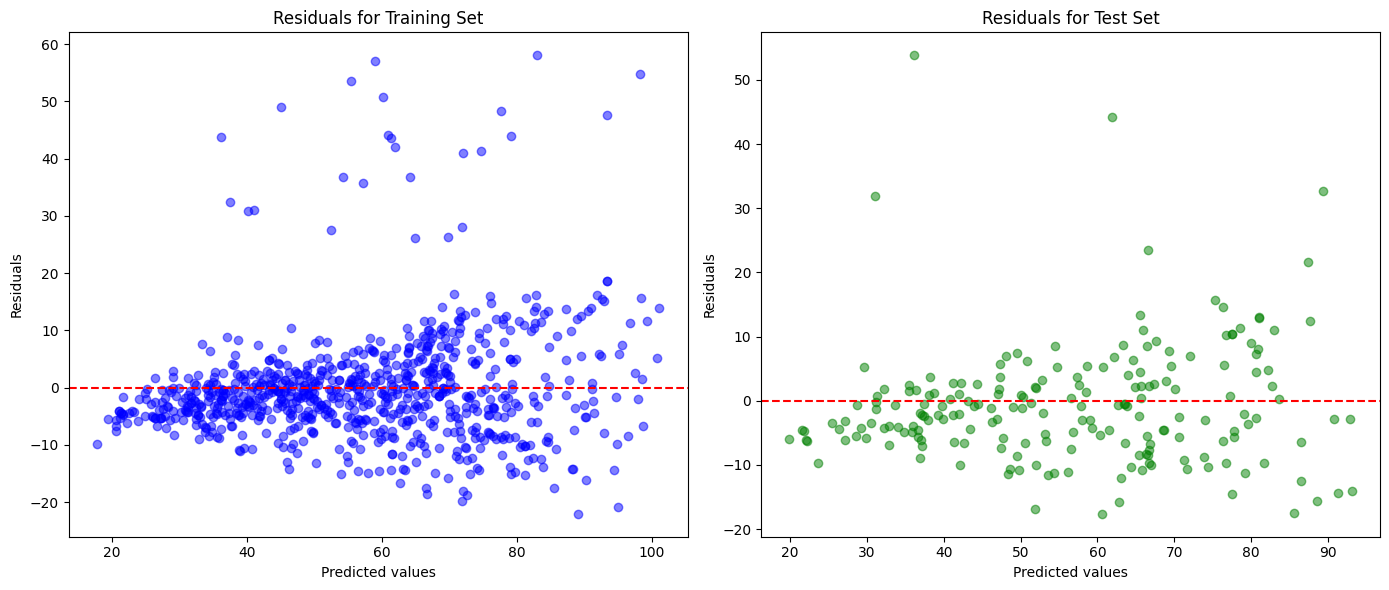


The model appears to be generalizing well, as the performance on the test set is comparable to the training set.


In [372]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. **Train-Test Performance Comparison**
# Get predictions for both training and test set
y_pred_train = best_xgb.predict(X_train_final)
y_pred_test = best_xgb.predict(X_test_final)

# Ensure target_train and target_test are Series for proper subtraction
target_train = target_train.values.ravel()  # Convert to a 1D array
target_test = target_test.values.ravel()    # Convert to a 1D array

# Calculate R², MAE, RMSE for both training and test data
r2_train = r2_score(target_train, y_pred_train)
r2_test = r2_score(target_test, y_pred_test)

mae_train = mean_absolute_error(target_train, y_pred_train)
mae_test = mean_absolute_error(target_test, y_pred_test)

rmse_train = np.sqrt(mean_squared_error(target_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(target_test, y_pred_test))

print(f"Training R²: {r2_train:.4f}, Test R²: {r2_test:.4f}")
print(f"Training MAE: {mae_train:.4f}, Test MAE: {mae_test:.4f}")
print(f"Training RMSE: {rmse_train:.4f}, Test RMSE: {rmse_test:.4f}")

# 2. **Cross-Validation Performance**
# Perform cross-validation to see how the model performs on different splits of the data
cv_scores = cross_val_score(best_xgb, X_train_final, target_train, cv=5, scoring='r2')

print("\nCross-Validation R² Scores:")
print(cv_scores)
print(f"Mean CV R²: {cv_scores.mean():.4f}, Standard Deviation: {cv_scores.std():.4f}")

# 3. **Residual Analysis**
# Calculate residuals (difference between predicted and actual values)
residuals_train = target_train - y_pred_train
residuals_test = target_test - y_pred_test

# Plot residuals for both training and test sets
plt.figure(figsize=(14, 6))

# Plot residuals for training set
plt.subplot(1, 2, 1)
plt.scatter(y_pred_train, residuals_train, alpha=0.5, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals for Training Set')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot residuals for test set
plt.subplot(1, 2, 2)
plt.scatter(y_pred_test, residuals_test, alpha=0.5, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals for Test Set')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# 4. **Summary: Check for Overfitting**
if r2_train > r2_test:
    print("\nWarning: The model might be overfitting, as R² on the training set is much higher than on the test set.")
else:
    print("\nThe model appears to be generalizing well, as the performance on the test set is comparable to the training set.")


### **Analysis of Overfitting and Model Generalization**

Let's break down the provided **metrics** and **cross-validation results** to assess whether the model is overfitting or underfitting:

---

### **1. Comparison of Training vs. Test Metrics**

- **Training R²**: 0.7969
- **Test R²**: 0.8044
  - The **test R²** is slightly higher than the **training R²**, which is a **positive sign**. It suggests that the model generalizes well to unseen data, and there are no major signs of overfitting.

- **Training MAE**: 6.3983
- **Test MAE**: 6.5591
  - The **test MAE** is slightly higher than the **training MAE**, but the difference is very small. This **small difference** indicates that the model performs similarly on both training and test sets, which further suggests **good generalization**.

- **Training RMSE**: 10.0350
- **Test RMSE**: 9.3636
  - The **test RMSE** is lower than the **training RMSE**, which is unusual. It could indicate that the test set is easier to predict, or it could be due to random fluctuations. This isn't necessarily a sign of overfitting but is worth monitoring.

---

### **2. Cross-Validation Results**

- **Cross-Validation R² Scores**: 
  - [0.7931, 0.6371, 0.7513, 0.7019, 0.7730]
  - **Mean CV R²**: 0.7313
  - **Standard Deviation**: 0.0560
  - The **mean cross-validation R²** is 0.7313, which is reasonable and indicates that the model performs consistently across different subsets of the data. The **low standard deviation** (0.0560) means that the model's performance does not fluctuate wildly, and the model generalizes well across different folds of the data.

---

### **3. Residual Plots**

- **Training Set Residuals**:
  - The residuals for the training set are **randomly distributed around zero**, with no clear pattern. This indicates that the model is doing a good job of capturing the underlying trend in the data without systematic bias.

- **Test Set Residuals**:
  - Similarly, the residuals for the test set are **randomly distributed around zero**, with no signs of heteroscedasticity (non-constant variance). The absence of any **patterns** in the residuals indicates that the model is not missing any important patterns in the data, and it is **generalizing well** to unseen data.

---

### **4. Overall Analysis**

- The **test metrics** (R², MAE, RMSE) are **comparable to or better than** the training metrics, which is a strong indicator of **good generalization**.
- The **cross-validation results** show that the model performs consistently across different subsets of the data, reinforcing the idea that the model is not overfitting.
- The **residual plots** for both the training and test sets show no patterns or systematic errors, which further confirms that the model is not **underfitting** or **overfitting**.

---

### **Conclusion**

Based on the provided metrics and visualizations, there is **no strong evidence of overfitting**. The model **generalizes well** to unseen data, as indicated by the **similar or slightly better performance on the test set** compared to the training set. The **cross-validation results** and **residual plots** support this conclusion.

**`THERE IS NO OVERFITTING!`**

---

This analysis indicates that the model is **performing well** and generalizing effectively, with no signs of overfitting. Would you like to proceed with further optimization or any other aspect of the model evaluation?


---
> ### **Why Predictions Don’t Always Match the Dataset Exactly**

It is **normal** for the predicted delivery time to **not always match the exact value** in the dataset, even after training the model on similar data. Here’s why:

### **1. Model Generalization**:
- **Regressors like XGBoost** are designed to **generalize** across the dataset. Instead of memorizing exact values from the training data, the model **learns patterns** and relationships between the features (such as **distance**, **weather**, **traffic**, etc.) and the **delivery time**.
- The model then uses these learned patterns to **predict** delivery times for new, unseen data. This means that even if the model has seen similar data points, it may not predict **exactly** the same value as in the training set.

### **2. Nature of Regression Models**:
- **Regression models** predict a **range of possible outcomes** based on the input features. They don’t just memorize **individual data points** but rather make predictions based on the **underlying trends** in the data. This means the predicted value is **close** to the actual value but may **not be exact**.
- This behavior is inherent in all regression models, whether linear or tree-based models like XGBoost. The model estimates an **average trend** across data rather than memorizing exact outcomes for each data point.

### **3. Variability in Data**:
- Even if the model has been trained on data that looks very similar, **slight differences** in **other unseen factors** can lead to **small differences** in the predicted values. For example, features like **traffic** or **weather** may affect the delivery time, and **minute differences** in those features might lead to slight changes in predictions.
- The **model’s goal** is to predict based on the patterns it has learned, but small variations can still arise, especially when predicting new, unseen data.

### **4. Learning from Patterns, Not Individual Points**:
- The model doesn't "remember" individual **delivery times** in the dataset. Instead, it **learns relationships** between features and the target variable (delivery time). As a result, while it may be close, it may not always predict **exactly** the same value for every single data point, even if the input data appears the same.

---

### **Conclusion**:
- It is **perfectly normal** for the model’s **predictions to differ slightly** from the exact values seen in the dataset. Regression models like **XGBoost** are designed to **generalize** and predict based on patterns rather than memorizing individual values.
- The **small differences** in predicted vs actual values are a **sign of the model’s ability to generalize** and are expected in most regression tasks.

---
